In [44]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models, regularizers, activations, callbacks, optimizers, backend as K
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

from tensorflow.keras import models, layers, regularizers, callbacks, optimizers
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Add, Concatenate
import shap

from tensorflow.keras.models import load_model

pd.set_option('display.max_columns', None)


/home/21827840/uni/ML/assignment/tf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def remove_outliers_iqr(df, numeric_cols):
    cleaned_df = df.copy()
    total_outliers = 0

    for col in numeric_cols:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = cleaned_df[(cleaned_df[col] < lower_bound) | (cleaned_df[col] > upper_bound)]
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)]

        outlier_count = len(outliers)
        if outlier_count > 0:
            print(f"\nColumn: {col}")
            print(f"  IQR range: [{lower_bound:.2f}, {upper_bound:.2f}]")
            print(f"  Count of outliers: {outlier_count}")
            print(f"  Sample outlier values:\n{outliers[col].head(5).to_string(index=False)}")

        total_outliers += outlier_count

    print(f"\nTotal outliers removed: {total_outliers}")
    return cleaned_df




def feature_engineer(data):
    
    data["Liquid Boiling Temperature"] = data["Liquid Boiling Temperature"] +273.15
    data["Liquid Critical Temperature"] = data["Liquid Critical Temperature"] +273.15
    data["Tank Volume"] = data["Tank Width"] * data["Tank Length"] * data["Tank Height"]  
    data["HeightRatio"]= data["Vapour Height"] / data["Tank Height"] 
    data["Superheat Margin"] = data["Liquid Temperature"] - data["Liquid Boiling Temperature"]
    # Total Energy (approximate thermal energy in the tank)
    data["Liquid Volume"] = data["Liquid Ratio"] * data["Tank Volume"]
    data["Total Energy"] = data["Liquid Volume"] * data["Superheat Margin"]

    # (BLEVE assumed at tank center top)
    data["Sensor Distance to BLEVE"] = (
        data["Sensor Position x"]**2 +
        data["Sensor Position y"]**2 +
        (data["Sensor Position z"] - data["BLEVE Height"])**2
    ) ** 0.5
    data = pd.get_dummies(data, columns=["Sensor Position Side"], prefix="Side")
    data = pd.get_dummies(data, columns=["Status"], prefix="Status")
    return data

def cleanColumns(columns):
    return [re.sub(r'\s*\([^)]*\)', '', col).strip() for col in columns]

def applyConstraints(data):
    return data[(data['Tank Width'] > 0) & 
                (data['Tank Length'] > 0) & 
                (data['Tank Height'] > 0) & 
                (data['Vapour Height'] >= 0) &
                (data['Vapour Temperature'] > 0) &
                (data['Liquid Temperature'] > 0)]

def handleMisspelling(data):
    data["Status"] = data["Status"].str.lower().str.replace(' ', '')
    data['Status'] = data['Status'].apply(lambda x: 'superheated' if 'h' in x else ('subcooled' if 'c' in x else x))
    return data["Status"]



def remove_highly_correlated_features(df, threshold=0.9):
    corr_matrix = df.corr(numeric_only=True).abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    print("Highly correlated features to drop:", to_drop)
    return df.drop(columns=to_drop)





def preprocess(data,test_dataset=False,feature_eng = True):
    # Initial row count
    initial_rows = len(data)
    print(f"Initial rows: {initial_rows}")

    # Clean column names
    data.columns = cleanColumns(data.columns)

    # Drop 'Unnamed: 0' column
    if "Unnamed: 0" in data.columns:
        data = data.drop(["Unnamed: 0"], axis="columns")

    # Drop rows with missing values
    before_na = len(data)
    data = data.dropna(axis=0)
    after_na = len(data)
    print(f"Rows removed due to NA: {before_na - after_na}")

    # Logical constraints
    before_constraints = len(data)
    data = applyConstraints(data)
    after_constraints = len(data)
    print(f"Rows removed due to logical constraints: {before_constraints - after_constraints}")

    # Drop duplicates (if not test dataset)
    if not test_dataset:
        before_duplicates = len(data)
        data = data.drop_duplicates()
        after_duplicates = len(data)
        print(f"Rows removed as duplicates: {before_duplicates - after_duplicates}")

    # Standardize 'Status' column
    data["Status"] = handleMisspelling(data)

    # Remove outliers (if not test dataset)
    if not test_dataset:
        numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
        before_outliers = len(data)
        data = remove_outliers_iqr(data, numeric_cols)
        after_outliers = len(data)
        print(f"Rows removed as outliers: {before_outliers - after_outliers}")

    # Final row count
    final_rows = len(data)
    print(f"Final rows: {final_rows}")
    print(f"Total rows removed: {initial_rows - final_rows}")
    data = pd.get_dummies(data, columns=["Sensor Position Side"], prefix="Side")
    data = pd.get_dummies(data, columns=["Status"], prefix="Status")

    y =  None
    if (not test_dataset):
        y= data[ "Target Pressure"] 
        data = data.drop(["Target Pressure"], axis="columns")
    
    # StandardScaler for inputs
    scaler = StandardScaler()

    X_scaled = scaler.fit_transform(data)
    return X_scaled,y



def load_data(csvFileName):
    data = pd.read_csv(csvFileName)
    X_scaled,y = preprocess(data);
    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    # print("Training Set Size:", X_train.shape)
    # print("Validation Set Size:", X_val.shape)
    return  X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = load_data("train.csv")


Initial rows: 10050
Rows removed due to NA: 110
Rows removed due to logical constraints: 0
Rows removed as duplicates: 50

Column: Tank Failure Pressure
  IQR range: [-16.27, 62.29]
  Count of outliers: 48
  Sample outlier values:
1446.628788
3404.750305
1722.348566
4095.753928
2379.656661

Column: Vapour Height
  IQR range: [-0.79, 2.41]
  Count of outliers: 38
  Sample outlier values:
2.60
2.59
2.59
2.61
2.60

Column: Sensor Position y
  IQR range: [-9.47, 15.53]
  Count of outliers: 33
  Sample outlier values:
16.2
16.2
16.2
16.2
16.2

Column: Sensor Position z
  IQR range: [-9.90, 14.90]
  Count of outliers: 33
  Sample outlier values:
15.7
15.7
15.7
15.7
15.7

Column: Target Pressure
  IQR range: [-0.36, 0.88]
  Count of outliers: 882
  Sample outlier values:
1.093819
1.091484
1.036741
1.163416
1.136221

Total outliers removed: 1034
Rows removed as outliers: 1034
Final rows: 8856
Total rows removed: 1194


In [65]:


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

def train_xgboost():
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    pred = best_model.predict(X_val)
    return best_model, mean_squared_error(y_val, pred), r2_score(y_val, pred)




from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

def train_svr():
    param_grid = {
        'svr__C': [1, 10, 100],
        'svr__epsilon': [0.01, 0.1,0.5],
        'svr__kernel': ['rbf']
    }

    pipeline = make_pipeline( SVR())
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    pred = best_model.predict(X_val)
    return best_model, mean_squared_error(y_val, pred), r2_score(y_val, pred)



train_xgboost()



Fitting 3 folds for each of 32 candidates, totalling 96 fits


/home/21827840/uni/ML/assignment/tf/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
12 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/21827840/uni/ML/assignment/tf/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/21827840/uni/ML/assignment/tf/lib/python3.12/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/home/21827840/uni/ML/assignment/tf/lib/python3.12/site-packages/xgboost/sklearn.py", line 1222

KeyboardInterrupt: 

ValueError: not enough values to unpack (expected 3, got 1)

In [ ]:
svrModel.
mse
r2

AttributeError: 'Pipeline' object has no attribute 'kernel'

In [50]:






def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))


def build_nn():
    model = models.Sequential([
        layers.Dense(256, activation='mish', input_shape=(X_train.shape[1],),
                    kernel_regularizer=regularizers.l2(1e-5)),
        layers.Dropout(0.1),
        layers.Dense(256, activation='mish', kernel_regularizer=regularizers.l2(1e-5)),
        layers.Dropout(0.1),
        layers.Dense(256, activation='mish', kernel_regularizer=regularizers.l2(1e-5)),
        layers.Dropout(0.1),
        layers.Dense(1, activation='softplus')
    ])

    optimizer = optimizers.SGD(learning_rate=0.1, momentum=0.9)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    optimizer = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # Callbacks
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss', patience=100, restore_best_weights=True
    )
    history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1,
    
)
    return model

build_nn()








Epoch 1/500


/home/21827840/uni/ML/assignment/tf/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0331 - mae: 0.1104 - val_loss: 0.0118 - val_mae: 0.0554
Epoch 2/500
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0118 - mae: 0.0565 - val_loss: 0.0104 - val_mae: 0.0501
Epoch 3/500
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0101 - mae: 0.0504 - val_loss: 0.0095 - val_mae: 0.0478
Epoch 4/500
  1/222 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0075 - mae: 0.0398

KeyboardInterrupt: 

In [21]:





model = load_model('best.keras')







# Evaluate the model on the validation dataset only
val_loss, val_mae = model.evaluate(X_val, y_val, batch_size=512, verbose=1)

# Print the results
print(f"Validation Loss: {val_loss}")
print(f"Validation MAE: {val_mae}")


# # Train the model
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=2000,
#     batch_size=512,
#     callbacks=[early_stop],
#     verbose=1
# )

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1006 - mae: 0.0965
Validation Loss: 0.09531672298908234
Validation MAE: 0.09574490785598755


In [9]:
model.save('best.keras')

NameError: name 'history' is not defined

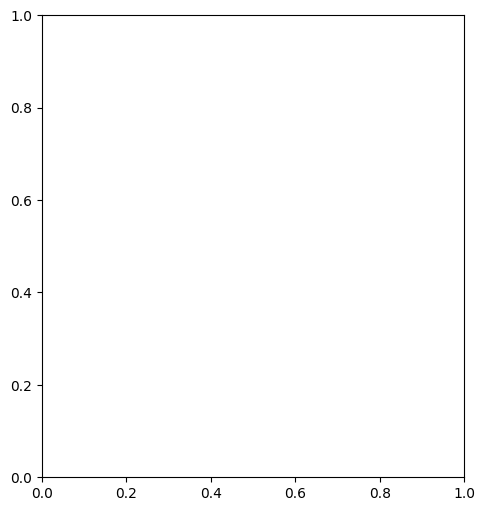

In [10]:


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training & Validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training & Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [46]:

from tensorflow.keras.layers import Input , Dense

def build_residual_block(x, units, dropout_rate=0.2):
    """Build a residual block with skip connections"""
    # Store the input for the skip connection
    skip = x
    
    # Main path
    x = Dense(units, activation=mish, kernel_regularizer=regularizers.l2(1e-5))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(units, activation=mish, kernel_regularizer=regularizers.l2(1e-5))(x)
    x = BatchNormalization()(x)
    
    # Add skip connection if dimensions match, otherwise project
    if skip.shape[-1] != units:
        skip = Dense(units, kernel_regularizer=regularizers.l2(1e-5))(skip)
    
    # Add skip connection
    x = Add()([x, skip])
    x = Dropout(dropout_rate)(x)
    
    return x

def build_advanced_nn(input_shape, learning_rate=0.001):
    """Build an advanced neural network with residual connections"""
    # Input layer
    inputs = Input(shape=(input_shape,))
    
    # Initial dense layer
    x = Dense(128, activation=mish, kernel_regularizer=regularizers.l2(1e-5))(inputs)
    x = BatchNormalization()(x)
    
    # Residual blocks
    x = build_residual_block(x, 256, dropout_rate=0.2)
    x = build_residual_block(x, 256, dropout_rate=0.2)
    x = build_residual_block(x, 128, dropout_rate=0.2)
    
    # Output layer
    outputs = Dense(1, activation='softplus')(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile with AMSGrad variant of Adam optimizer (more stable than standard Adam)
    optimizer = optimizers.Adam(learning_rate=learning_rate, amsgrad=True)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

def train_model(model, batch_size=32, epochs=1000):
    """Train model with advanced scheduling and callbacks"""
    # Learning rate scheduler
    lr_scheduler = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=30,
        min_lr=1e-6,
        verbose=1
    )
    
    # Early stopping
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=100,
        restore_best_weights=True,
        verbose=1
    )
    
    # Model checkpoint
    checkpoint = callbacks.ModelCheckpoint(
        'best_bleve_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    # Train with callbacks
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop, lr_scheduler, checkpoint],
        verbose=1
    )
    
    return model, history


train_model(build_advanced_nn(X_train.shape[1]))

Epoch 1/1000


2025-05-04 14:17:28.905339: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 12 bytes spill stores, 12 bytes spill loads

2025-05-04 14:17:28.942106: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 8 bytes spill stores, 8 bytes spill loads

2025-05-04 14:17:28.993606: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4', 40 bytes spill stores, 40 bytes spill loads

2025-05-04 14:17:29.652308: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 40 bytes spill stores, 40 bytes spill loads

2025-05-04 14:17:29.698716: I external/local_xla/xla/s

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.3073 - mae: 0.7240
Epoch 1: val_loss improved from inf to 0.08407, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 2.3008 - mae: 0.7226 - val_loss: 0.0841 - val_mae: 0.1886 - learning_rate: 0.0010
Epoch 2/1000
218/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1520 - mae: 0.2453
Epoch 2: val_loss did not improve from 0.08407
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1515 - mae: 0.2451 - val_loss: 0.1045 - val_mae: 0.2278 - learning_rate: 0.0010
Epoch 3/1000
215/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1121 - mae: 0.2325
Epoch 3: val_loss did not improve from 0.08407
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1120 - mae: 0.2324 - val_loss: 0.1053 - val_mae: 0.2280 - learning_rate: 0.0010
Epoch 4/1000
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1118 - mae: 0.2326
Epoch 4: val_loss did not improve from 0.08407
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1117 - mae: 0.2325 - val_loss: 0.1014 - val_mae: 0.2268 - learning_rate: 0.0010
Epoch 5/1000
219/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1016 - mae: 0.2223
E

222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1010 - mae: 0.2216 - val_loss: 0.0835 - val_mae: 0.2033 - learning_rate: 0.0010
Epoch 13/1000
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0942 - mae: 0.2092
Epoch 13: val_loss did not improve from 0.08350
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0942 - mae: 0.2093 - val_loss: 0.0857 - val_mae: 0.2042 - learning_rate: 0.0010
Epoch 14/1000
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0942 - mae: 0.2124
Epoch 14: val_loss did not improve from 0.08350
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0942 - mae: 0.2124 - val_loss: 0.0852 - val_mae: 0.2045 - learning_rate: 0.0010
Epoch 15/1000
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0923 - mae: 0.2087
Epoch 15: val_loss improved from 0.08350 to 0.07157, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0923 - mae: 0.2086 - val_loss: 0.0716 - val_mae: 0.1813 - learning_rate: 0.0010
Epoch 16/1000
218/222 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0878 - mae: 0.1991
Epoch 16: val_loss improved from 0.07157 to 0.06237, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0877 - mae: 0.1990 - val_loss: 0.0624 - val_mae: 0.1674 - learning_rate: 0.0010
Epoch 17/1000
213/222 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0850 - mae: 0.1935
Epoch 17: val_loss improved from 0.06237 to 0.05993, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0851 - mae: 0.1935 - val_loss: 0.0599 - val_mae: 0.1581 - learning_rate: 0.0010
Epoch 18/1000
218/222 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0851 - mae: 0.1945
Epoch 18: val_loss improved from 0.05993 to 0.04501, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0850 - mae: 0.1943 - val_loss: 0.0450 - val_mae: 0.1325 - learning_rate: 0.0010
Epoch 19/1000
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0797 - mae: 0.1802
Epoch 19: val_loss did not improve from 0.04501
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0797 - mae: 0.1802 - val_loss: 0.0610 - val_mae: 0.1596 - learning_rate: 0.0010
Epoch 20/1000
214/222 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0719 - mae: 0.1716
Epoch 20: val_loss did not improve from 0.04501
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0719 - mae: 0.1715 - val_loss: 0.0469 - val_mae: 0.1305 - learning_rate: 0.0010
Epoch 21/1000
211/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0683 - mae: 0.1655
Epoch 21: val_loss improved from 0.04501 to 0.03921, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0683 - mae: 0.1655 - val_loss: 0.0392 - val_mae: 0.1135 - learning_rate: 0.0010
Epoch 22/1000
219/222 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0653 - mae: 0.1602
Epoch 22: val_loss improved from 0.03921 to 0.03911, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0652 - mae: 0.1601 - val_loss: 0.0391 - val_mae: 0.1127 - learning_rate: 0.0010
Epoch 23/1000
217/222 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0607 - mae: 0.1509
Epoch 23: val_loss improved from 0.03911 to 0.03543, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0607 - mae: 0.1509 - val_loss: 0.0354 - val_mae: 0.0993 - learning_rate: 0.0010
Epoch 24/1000
215/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0565 - mae: 0.1441
Epoch 24: val_loss improved from 0.03543 to 0.02964, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0565 - mae: 0.1441 - val_loss: 0.0296 - val_mae: 0.0857 - learning_rate: 0.0010
Epoch 25/1000
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0585 - mae: 0.1462
Epoch 25: val_loss improved from 0.02964 to 0.02928, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0585 - mae: 0.1462 - val_loss: 0.0293 - val_mae: 0.0850 - learning_rate: 0.0010
Epoch 26/1000
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0528 - mae: 0.1371
Epoch 26: val_loss improved from 0.02928 to 0.02598, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0528 - mae: 0.1371 - val_loss: 0.0260 - val_mae: 0.0738 - learning_rate: 0.0010
Epoch 27/1000
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0496 - mae: 0.1284
Epoch 27: val_loss did not improve from 0.02598
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0496 - mae: 0.1284 - val_loss: 0.0315 - val_mae: 0.0865 - learning_rate: 0.0010
Epoch 28/1000
219/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0488 - mae: 0.1292
Epoch 28: val_loss improved from 0.02598 to 0.02515, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0488 - mae: 0.1292 - val_loss: 0.0251 - val_mae: 0.0674 - learning_rate: 0.0010
Epoch 29/1000
216/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0446 - mae: 0.1190
Epoch 29: val_loss improved from 0.02515 to 0.02510, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0446 - mae: 0.1189 - val_loss: 0.0251 - val_mae: 0.0671 - learning_rate: 0.0010
Epoch 30/1000
214/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0444 - mae: 0.1181
Epoch 30: val_loss improved from 0.02510 to 0.02482, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0444 - mae: 0.1181 - val_loss: 0.0248 - val_mae: 0.0653 - learning_rate: 0.0010
Epoch 31/1000
216/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0434 - mae: 0.1150
Epoch 31: val_loss improved from 0.02482 to 0.02421, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0434 - mae: 0.1149 - val_loss: 0.0242 - val_mae: 0.0637 - learning_rate: 0.0010
Epoch 32/1000
218/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0403 - mae: 0.1094
Epoch 32: val_loss improved from 0.02421 to 0.02352, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0403 - mae: 0.1094 - val_loss: 0.0235 - val_mae: 0.0605 - learning_rate: 0.0010
Epoch 33/1000
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0388 - mae: 0.1054
Epoch 33: val_loss improved from 0.02352 to 0.02338, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0388 - mae: 0.1054 - val_loss: 0.0234 - val_mae: 0.0595 - learning_rate: 0.0010
Epoch 34/1000
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0371 - mae: 0.1021
Epoch 34: val_loss improved from 0.02338 to 0.02329, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0371 - mae: 0.1021 - val_loss: 0.0233 - val_mae: 0.0586 - learning_rate: 0.0010
Epoch 35/1000
218/222 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0372 - mae: 0.1005
Epoch 35: val_loss improved from 0.02329 to 0.02300, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0372 - mae: 0.1005 - val_loss: 0.0230 - val_mae: 0.0588 - learning_rate: 0.0010
Epoch 36/1000
214/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0345 - mae: 0.0946
Epoch 36: val_loss improved from 0.02300 to 0.02269, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0346 - mae: 0.0947 - val_loss: 0.0227 - val_mae: 0.0560 - learning_rate: 0.0010
Epoch 37/1000
215/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0345 - mae: 0.0957
Epoch 37: val_loss improved from 0.02269 to 0.02266, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0346 - mae: 0.0957 - val_loss: 0.0227 - val_mae: 0.0551 - learning_rate: 0.0010
Epoch 38/1000
216/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0344 - mae: 0.0948
Epoch 38: val_loss improved from 0.02266 to 0.02243, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0344 - mae: 0.0948 - val_loss: 0.0224 - val_mae: 0.0554 - learning_rate: 0.0010
Epoch 39/1000
216/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0344 - mae: 0.0941
Epoch 39: val_loss improved from 0.02243 to 0.02234, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0344 - mae: 0.0940 - val_loss: 0.0223 - val_mae: 0.0537 - learning_rate: 0.0010
Epoch 40/1000
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0325 - mae: 0.0899
Epoch 40: val_loss improved from 0.02234 to 0.02226, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0325 - mae: 0.0899 - val_loss: 0.0223 - val_mae: 0.0543 - learning_rate: 0.0010
Epoch 41/1000
218/222 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0331 - mae: 0.0910
Epoch 41: val_loss improved from 0.02226 to 0.02200, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0331 - mae: 0.0910 - val_loss: 0.0220 - val_mae: 0.0531 - learning_rate: 0.0010
Epoch 42/1000
217/222 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0317 - mae: 0.0870
Epoch 42: val_loss improved from 0.02200 to 0.02189, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0317 - mae: 0.0870 - val_loss: 0.0219 - val_mae: 0.0519 - learning_rate: 0.0010
Epoch 43/1000
218/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0313 - mae: 0.0861
Epoch 43: val_loss did not improve from 0.02189
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0313 - mae: 0.0861 - val_loss: 0.0219 - val_mae: 0.0524 - learning_rate: 0.0010
Epoch 44/1000
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0307 - mae: 0.0850
Epoch 44: val_loss did not improve from 0.02189
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0307 - mae: 0.0850 - val_loss: 0.0222 - val_mae: 0.0541 - learning_rate: 0.0010
Epoch 45/1000
210/222 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0310 - mae: 0.0857
Epoch 45: val_loss did not improve from 0.02189
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0310 - mae: 0.0855 - val_loss: 0.0220 - val_mae: 0.0529 - learning_rate: 0.0010
Epoch 46/1000
217/222 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0297 - mae: 0.0

222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0288 - mae: 0.0793 - val_loss: 0.0217 - val_mae: 0.0516 - learning_rate: 0.0010
Epoch 49/1000
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0284 - mae: 0.0776
Epoch 49: val_loss did not improve from 0.02168
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0284 - mae: 0.0776 - val_loss: 0.0221 - val_mae: 0.0533 - learning_rate: 0.0010
Epoch 50/1000
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0281 - mae: 0.0778
Epoch 50: val_loss improved from 0.02168 to 0.02163, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0281 - mae: 0.0778 - val_loss: 0.0216 - val_mae: 0.0511 - learning_rate: 0.0010
Epoch 51/1000
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0280 - mae: 0.0770
Epoch 51: val_loss improved from 0.02163 to 0.02157, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0280 - mae: 0.0770 - val_loss: 0.0216 - val_mae: 0.0510 - learning_rate: 0.0010
Epoch 52/1000
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0279 - mae: 0.0767
Epoch 52: val_loss did not improve from 0.02157
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0279 - mae: 0.0767 - val_loss: 0.0218 - val_mae: 0.0520 - learning_rate: 0.0010
Epoch 53/1000
216/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0272 - mae: 0.0753
Epoch 53: val_loss did not improve from 0.02157
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0272 - mae: 0.0753 - val_loss: 0.0217 - val_mae: 0.0519 - learning_rate: 0.0010
Epoch 54/1000
218/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0279 - mae: 0.0760
Epoch 54: val_loss did not improve from 0.02157
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0279 - mae: 0.0760 - val_loss: 0.0219 - val_mae: 0.0529 - learning_rate: 0.0010
Epoch 55/1000
219/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0266 - mae: 0.0

222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0266 - mae: 0.0731 - val_loss: 0.0215 - val_mae: 0.0511 - learning_rate: 0.0010
Epoch 56/1000
214/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0277 - mae: 0.0765
Epoch 56: val_loss improved from 0.02154 to 0.02144, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0277 - mae: 0.0764 - val_loss: 0.0214 - val_mae: 0.0506 - learning_rate: 0.0010
Epoch 57/1000
217/222 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0268 - mae: 0.0732
Epoch 57: val_loss did not improve from 0.02144
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0268 - mae: 0.0732 - val_loss: 0.0218 - val_mae: 0.0531 - learning_rate: 0.0010
Epoch 58/1000
208/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0270 - mae: 0.0737
Epoch 58: val_loss did not improve from 0.02144
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0270 - mae: 0.0737 - val_loss: 0.0215 - val_mae: 0.0518 - learning_rate: 0.0010
Epoch 59/1000
216/222 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0263 - mae: 0.0717
Epoch 59: val_loss improved from 0.02144 to 0.02135, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0263 - mae: 0.0717 - val_loss: 0.0214 - val_mae: 0.0509 - learning_rate: 0.0010
Epoch 60/1000
217/222 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0261 - mae: 0.0716
Epoch 60: val_loss did not improve from 0.02135
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0261 - mae: 0.0717 - val_loss: 0.0214 - val_mae: 0.0516 - learning_rate: 0.0010
Epoch 61/1000
213/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0262 - mae: 0.0714
Epoch 61: val_loss improved from 0.02135 to 0.02125, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0262 - mae: 0.0714 - val_loss: 0.0213 - val_mae: 0.0504 - learning_rate: 0.0010
Epoch 62/1000
213/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0264 - mae: 0.0719
Epoch 62: val_loss did not improve from 0.02125
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0264 - mae: 0.0718 - val_loss: 0.0214 - val_mae: 0.0514 - learning_rate: 0.0010
Epoch 63/1000
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0263 - mae: 0.0721
Epoch 63: val_loss did not improve from 0.02125
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0263 - mae: 0.0720 - val_loss: 0.0218 - val_mae: 0.0534 - learning_rate: 0.0010
Epoch 64/1000
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0259 - mae: 0.0701
Epoch 64: val_loss did not improve from 0.02125
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0259 - mae: 0.0701 - val_loss: 0.0213 - val_mae: 0.0509 - learning_rate: 0.0010
Epoch 65/1000
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0254 - mae: 0.0

222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0249 - mae: 0.0672 - val_loss: 0.0212 - val_mae: 0.0507 - learning_rate: 0.0010
Epoch 74/1000
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0252 - mae: 0.0677
Epoch 74: val_loss improved from 0.02121 to 0.02115, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0252 - mae: 0.0677 - val_loss: 0.0211 - val_mae: 0.0502 - learning_rate: 0.0010
Epoch 75/1000
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0246 - mae: 0.0662
Epoch 75: val_loss did not improve from 0.02115
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0246 - mae: 0.0662 - val_loss: 0.0215 - val_mae: 0.0519 - learning_rate: 0.0010
Epoch 76/1000
218/222 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0251 - mae: 0.0674
Epoch 76: val_loss improved from 0.02115 to 0.02109, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0251 - mae: 0.0674 - val_loss: 0.0211 - val_mae: 0.0496 - learning_rate: 0.0010
Epoch 77/1000
217/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0244 - mae: 0.0654
Epoch 77: val_loss did not improve from 0.02109
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0244 - mae: 0.0654 - val_loss: 0.0212 - val_mae: 0.0507 - learning_rate: 0.0010
Epoch 78/1000
215/222 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0248 - mae: 0.0659
Epoch 78: val_loss improved from 0.02109 to 0.02106, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0248 - mae: 0.0659 - val_loss: 0.0211 - val_mae: 0.0499 - learning_rate: 0.0010
Epoch 79/1000
219/222 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0245 - mae: 0.0656
Epoch 79: val_loss did not improve from 0.02106
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0245 - mae: 0.0656 - val_loss: 0.0212 - val_mae: 0.0505 - learning_rate: 0.0010
Epoch 80/1000
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0241 - mae: 0.0643
Epoch 80: val_loss improved from 0.02106 to 0.02082, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0241 - mae: 0.0643 - val_loss: 0.0208 - val_mae: 0.0489 - learning_rate: 0.0010
Epoch 81/1000
221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0239 - mae: 0.0643
Epoch 81: val_loss did not improve from 0.02082
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0239 - mae: 0.0643 - val_loss: 0.0209 - val_mae: 0.0495 - learning_rate: 0.0010
Epoch 82/1000
215/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0244 - mae: 0.0661
Epoch 82: val_loss improved from 0.02082 to 0.02074, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0244 - mae: 0.0660 - val_loss: 0.0207 - val_mae: 0.0486 - learning_rate: 0.0010
Epoch 83/1000
219/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0236 - mae: 0.0630
Epoch 83: val_loss did not improve from 0.02074
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0236 - mae: 0.0630 - val_loss: 0.0209 - val_mae: 0.0492 - learning_rate: 0.0010
Epoch 84/1000
217/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0239 - mae: 0.0631
Epoch 84: val_loss did not improve from 0.02074
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0239 - mae: 0.0631 - val_loss: 0.0208 - val_mae: 0.0490 - learning_rate: 0.0010
Epoch 85/1000
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0237 - mae: 0.0628
Epoch 85: val_loss improved from 0.02074 to 0.02070, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0237 - mae: 0.0628 - val_loss: 0.0207 - val_mae: 0.0483 - learning_rate: 0.0010
Epoch 86/1000
216/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0236 - mae: 0.0623
Epoch 86: val_loss did not improve from 0.02070
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0236 - mae: 0.0623 - val_loss: 0.0209 - val_mae: 0.0492 - learning_rate: 0.0010
Epoch 87/1000
220/222 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0246 - mae: 0.0647
Epoch 87: val_loss did not improve from 0.02070
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0246 - mae: 0.0647 - val_loss: 0.0207 - val_mae: 0.0493 - learning_rate: 0.0010
Epoch 88/1000
214/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0243 - mae: 0.0651
Epoch 88: val_loss improved from 0.02070 to 0.02066, saving model to best_bleve_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0243 - mae: 0.0650 - val_loss: 0.0207 - val_mae: 0.0483 - learning_rate: 0.0010
Epoch 89/1000
215/222 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0248 - mae: 0.0665
Epoch 89: val_loss did not improve from 0.02066
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0248 - mae: 0.0664 - val_loss: 0.0208 - val_mae: 0.0493 - learning_rate: 0.0010
Epoch 90/1000
217/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0239 - mae: 0.0638
Epoch 90: val_loss did not improve from 0.02066
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0239 - mae: 0.0638 - val_loss: 0.0209 - val_mae: 0.0492 - learning_rate: 0.0010
Epoch 91/1000
217/222 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0234 - mae: 0.0612
Epoch 91: val_loss did not improve from 0.02066
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0234 - mae: 0.0613 - val_loss: 0.0208 - val_mae: 0.0491 - learning_rate: 0.0010
Epoch 92/1000
 30/222 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0240 - mae: 0.0

KeyboardInterrupt: 

In [ ]:
# Assuming you have X_test and y_test prepared
# 1. Evaluate the model on the test set
test_data =   pd.read_csv("test.csv")
y_test = pd.read_csv("sample_prediction.csv")
predData = y_test["Target Pressure (bar)"]
test_scaled,_ = preprocess(test_data,True)
test_loss, test_mae = model.evaluate(test_scaled, predData)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")


y_pred = model.predict(test_scaled).flatten()  # Ensure it's a 1D array

# 2. Get the true target values
y_true = y_test["Target Pressure (bar)"].values



# 3. Calculate MAPE (excluding zero targets to avoid division by zero)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))

# 4. Compute and print MAPE
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"MAPE: {mape/10}")


# Assuming the ID column in the test data is named 'ID'
# 1. Create a DataFrame with the predictions and IDs
output_df = pd.DataFrame({
    'ID': y_test['ID'],  # Assuming 'ID' is in the test_data
    'Target Pressure (bar)': y_pred  # The predicted values
})

# 2. Save the DataFrame to a CSV file
output_df.to_csv('predictions_output.csv', index=False)
print("Predictions have been saved to 'predictions_output.csv'.")


   Tank Failure Pressure  Liquid Ratio  Tank Width  Tank Length  Tank Height  \
0                   37.9      0.412227         0.8          6.6          0.4   

   BLEVE Height  Vapour Height  Vapour Temperature  Liquid Temperature  \
0           0.8            0.2               317.6               337.5   

   Obstacle Distance to BLEVE  Obstacle Width  Obstacle Height  \
0                           7               9               12   

   Obstacle Thickness  Obstacle Angle  Liquid Critical Pressure  \
0                 0.6               0                      42.5   

   Liquid Boiling Temperature  Liquid Critical Temperature  Sensor ID  \
0                      231.15                       369.85          1   

   Sensor Position x  Sensor Position y  Sensor Position z  Tank Volume  \
0               8.05               -4.3               -0.7        2.112   

   HeightRatio  Superheat Margin  Side_1  Side_2  Side_3  Side_4  Side_5  \
0          0.5            106.35    True   False

In [ ]:
import keras_tuner as kt

def build_model(hp):
    model = models.Sequential()
    
    # Tunable units
    for i in range(hp.Int("num_layers", 2, 4)):
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=128, max_value=512, step=64),
            activation='mish',
            kernel_regularizer=regularizers.l2(hp.Choice('l2_reg', [1e-5, 1e-4, 1e-3]))
        ))
        model.add(layers.Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(layers.Dense(1, activation='softplus'))
    
    # Compile
    optimizer = optimizers.SGD(
        learning_rate=hp.Choice('learning_rate', [0.01, 0.05, 0.1]),
        momentum=hp.Float('momentum', min_value=0.5, max_value=0.95, step=0.05)
    )
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model





tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='mish_model'
)

# Register Mish
tf.keras.utils.get_custom_objects().update({'mish': mish})

# Run search
tuner.search(
    X_train, y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=10)],
    verbose=1
)


best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

print("Best hyperparameters:")
for key in best_hps.values:
    print(f"{key}: {best_hps.get(key)}")



Reloading Tuner from tuner_dir/mish_model/tuner0.json

Search: Running Trial #14

Value             |Best Value So Far |Hyperparameter
4                 |2                 |num_layers
320               |192               |units_0
0.001             |0.0001            |l2_reg
0.5               |0.1               |dropout_0
320               |512               |units_1
0.4               |0.4               |dropout_1
0.01              |0.1               |learning_rate
0.7               |0.7               |momentum
384               |128               |units_2
0.2               |0.1               |dropout_2
512               |128               |units_3
0.2               |0.1               |dropout_3

Epoch 1/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.2419 - mae: 0.2426 - val_loss: 1.1589 - val_mae: 0.1386
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1487 - mae: 0.1238 - val_loss: 1.1178 - val_mae: 0.1137
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - lo

KeyboardInterrupt: 